In [1]:
# Imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import cv2
import os
import json
import math
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import F1Score,JaccardIndex
from torch_poly_lr_decay import PolynomialLRDecay
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

random.seed(1)

# Import TuSimple loader
import sys
sys.path.insert(0,'../resources/')
from tusimple import TuSimple
from mask_transformer import MaskTransformer
from vit import ViT
import utils
from linear import DecoderLinear
from mlp_decoder import DecoderMLP

/home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/dimitris/anaconda3/envs/py10/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# ROOT DIRECTORIES
root_dir = os.path.dirname(os.getcwd())
annotated_dir = os.path.join(root_dir,'datasets/tusimple/train_set/annotations')
clips_dir = os.path.join(root_dir,'datasets/tusimple/train_set/')
annotated = os.listdir(annotated_dir)

# Get path directories for clips and annotations for the TUSimple dataset + ground truth dictionary
annotations = list()
for gt_file in annotated:
    path = os.path.join(annotated_dir,gt_file)
    json_gt = [json.loads(line) for line in open(path)]
    annotations.append(json_gt)
    
annotations = [a for f in annotations for a in f]

In [3]:
dataset = TuSimple(train_annotations = annotations, train_img_dir = clips_dir, resize_to = (640,640), subset_size = 0.1, val_size= 0.2)

# Create train and validation splits / Always use del dataset to free memory after this
train_set, validation_set = dataset.train_val_split()
del dataset



In [48]:
# Create dataloaders and train the model
train_loader = DataLoader(train_set, batch_size = 3,shuffle= True, drop_last= True) 

gt_augmentations = transforms.Compose([transforms.RandomRotation(degrees=(10, 30)),
                                              transforms.RandomHorizontalFlip()])
  
train_augmentations = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225]),
                                          transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
                                        transforms.ColorJitter(brightness=0.25, contrast=0.1, saturation=0.4, hue=0.1)])
# Set a seed for augmentations
torch.manual_seed(212) 
    
for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Combine the inputs and targets into a single tensor
            data = torch.cat((inputs, targets), dim=1)
    
            
            # Apply the same augmentations to the combined tensor
            augmented_data = gt_augmentations(data)    
    
            # Split the augmented data back into individual inputs and targets
            inputs = augmented_data[:, :inputs.size(1)]
            targets = augmented_data[:, inputs.size(1):]
            
            inputs = train_augmentations(inputs)
            
            for i in range(0,len(inputs)):
                utils.plot_img_pred(inputs[i], targets[i])
            break

In [6]:
# Lane weight
pos_weight = utils.calculate_class_weight(train_set)
print(pos_weight)

tensor(38, dtype=torch.int32)


In [35]:
# Custom training function for the transformer pipeline with schedule and augmentations
def train(model, train_loader, val_loader = None, num_epochs=10, lr=0.01, weight_decay=0, lr_scheduler=True, lane_weight = None):
    # Set up loss function and optimizer
    criterion =  nn.BCEWithLogitsLoss(pos_weight= lane_weight)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    # Set up learning rate scheduler
    if lr_scheduler:
        scheduler = PolynomialLRDecay(optimizer, max_decay_steps=100, end_learning_rate=0.0001, power=0.9)

    # Set up device (GPU or CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    f1_score = F1Score(task="binary").to(device)
    iou_score = JaccardIndex(task= 'binary').to(device)
    
    train_augmentations = transforms.Compose([transforms.RandomRotation(degrees=(10, 30)),
                                              transforms.RandomHorizontalFlip()])
    
    # Set a seed for augmentations
    torch.manual_seed(42) 
    
    # Train the model
    for epoch in range(num_epochs):
        train_loss = 0
        train_iou = 0
        train_f1 = 0
        
        val_iou = 0
        val_f1 = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            model.train()
            # inputs, targets = inputs.to(device), targets.to(device)
            
            # Combine the inputs and targets into a single tensor
            data = torch.cat((inputs, targets), dim=1)
    
            
            # Apply the same augmentations to the combined tensor
            augmented_data = train_augmentations(data)    
    
            # Split the augmented data back into individual inputs and targets
            inputs = augmented_data[:, :inputs.size(1)].to(device)
            targets = augmented_data[:, inputs.size(1):].to(device)
      
            optimizer.zero_grad()
            outputs, eval_out = model(inputs)

            loss = criterion(outputs.to(device), targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            train_iou += iou_score(eval_out.to(device).detach(), targets)
            train_f1 += f1_score(eval_out.to(device).detach(),targets)
        
        if val_loader:
            model.eval()
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(val_loader): 
                
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                
                    val_iou += iou_score(outputs.to(device), targets)
                    val_f1 += f1_score(outputs.to(device),targets)
        
                val_iou /= len(val_loader)
                val_f1 /= len(val_loader)
            
        train_loss /= len(train_loader)
        train_iou /= len(train_loader)
        train_f1 /= len(train_loader)
        
        
        
     # Print progress
        if lr_scheduler:
            print('Epoch: {} - Train Loss: {:.4f} - Learning Rate: {:.6f} - Train_IoU: {:.5f} - Train_F1: {:.5f}'.format(epoch+1, train_loss,optimizer.param_groups[0]['lr'], train_iou, train_f1))
            scheduler.step()
            if val_loader:
                print('Val_F1: {:.5f}  - Val_IoU: {:.5f} '.format(val_f1,val_iou))
        else:
            print('Epoch: {} - Train Loss: {:.4f} - Train_IoU: {:.5f} - Train_F1: {:.5f}'.format(epoch+1, train_loss, train_iou, train_f1))

In [36]:
# Segmenter pipeline class (ViT + Masks predictor end-to-end)
class Segmenter(nn.Module):
    def __init__(self,encoder, decoder, image_size = (640,640), output_act = 'sigmoid', find_threshold = False):
        super().__init__()
        self.patch_size = encoder.patch_size
        self.encoder = encoder
        self.decoder = decoder
        self.image_size = image_size
        self.lane_threshold = 0.5
        self.roc_flag = find_threshold
        if output_act == 'sigmoid':
            self.activation = nn.Sigmoid()   
        elif output_act == 'relu':
            self.activation = nn.ReLU()
        
        
    # Forward pass of the pipeline
    def forward(self, im):
        H, W = self.image_size
        
        # Pass through the pre-trained vit backbone
        x = self.encoder(im, return_features=True)
        
        # Pass through the masks transformer
        masks = self.decoder(x)
        

        # Interpolate patch level class annotatations to pixel level and transform to original image size
        masks = F.interpolate(masks, size=(H, W), mode="bilinear")
        
        # Training time
        if self.training:
            class_prob_masks = self.activation(masks)
            predictions = torch.where(class_prob_masks > self.lane_threshold, torch.ones_like(class_prob_masks), torch.zeros_like(class_prob_masks))
            return masks, predictions
        
        elif self.roc_flag and not self.training:
            class_prob_masks = self.activation(masks)
            return class_prob_masks
        else:
            class_prob_masks = self.activation(masks)
            predictions = torch.where(class_prob_masks > self.lane_threshold, torch.ones_like(class_prob_masks), torch.zeros_like(class_prob_masks))
            return predictions
        
    # Count pipeline trainable parameters
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    # Load trained model
    def load_segmenter(self,path): 
        self.load_state_dict(torch.load(path,map_location=torch.device('cpu')))
            


In [14]:
# Create dataloaders and train the model
train_loader = DataLoader(train_set, batch_size= 2,shuffle= True, drop_last= True) 
validation_loader = DataLoader(validation_set,batch_size= 1, shuffle= True, drop_last= True) 

In [16]:
# Create Segmenter model
encoder = ViT(image_size=640, patch_size=16, num_classes=1, dim=768, depth=12, heads=12, 
            mlp_dim=3072, dropout=0.1,load_pre= True, pre_trained_path= '../pre-trained/jx_vit_base_p16_224-80ecf9dd.pth')
encoder.freeze_all_but_some([])
# decoder = MaskTransformer(n_classes= 1)
# decoder = DecoderMLP(n_classes = 1, d_encoder = 768)
decoder = DecoderLinear(n_classes = 1, d_encoder = 768)
model = Segmenter(encoder, decoder, find_threshold= False, output_act= 'sigmoid')
print(f'Number of trainable parameters : {model.count_parameters()}')

# model.load_segmenter('../models/segmenter.pth')

Succesfully created ViT with pre-trained weights...!
Number of trainable parameters : 769


In [17]:
# Train the model
train(model, train_loader,val_loader= None , num_epochs= 1, 
      lane_weight = pos_weight, lr_scheduler= False, lr = 0.001)

tensor([0.0000e+00, 3.5715e-04, 5.8281e-04, 1.3763e-03, 1.6632e-03, 1.7548e-03,
        2.0233e-03, 2.0599e-03, 2.0905e-03, 2.3286e-03, 2.3893e-03, 2.3955e-03,
        2.4079e-03, 2.5482e-03, 2.6597e-03, 2.7374e-03, 3.0487e-03, 3.5309e-03,
        3.7568e-03, 3.9062e-03, 4.5013e-03, 5.0801e-03, 5.1727e-03, 5.8318e-03,
        6.5092e-03, 7.2423e-03, 7.4615e-03, 7.5531e-03, 7.6007e-03, 7.6510e-03,
        8.2966e-03, 8.5140e-03, 8.6513e-03, 8.7637e-03, 8.7738e-03, 8.8959e-03,
        8.9264e-03, 9.1542e-03, 9.2439e-03, 9.2926e-03, 9.4329e-03, 9.9335e-03,
        9.9517e-03, 1.0162e-02, 1.0357e-02, 1.0574e-02, 1.0642e-02, 1.1719e-02,
        1.1948e-02, 1.1978e-02, 1.2088e-02, 1.2126e-02, 1.2139e-02, 1.2607e-02,
        1.2655e-02, 1.3863e-02, 1.5903e-02, 1.6293e-02, 1.6388e-02, 1.6556e-02,
        1.6902e-02, 1.8056e-02, 1.8173e-02, 1.8194e-02, 1.8295e-02, 1.8321e-02,
        1.8400e-02, 1.8698e-02, 1.9038e-02, 1.9531e-02, 2.0352e-02, 2.0986e-02,
        2.1118e-02, 2.1121e-02, 2.1504e-

KeyboardInterrupt: 

In [9]:
pred_probs, gts = utils.get_roc_probs(model,validation_loader)

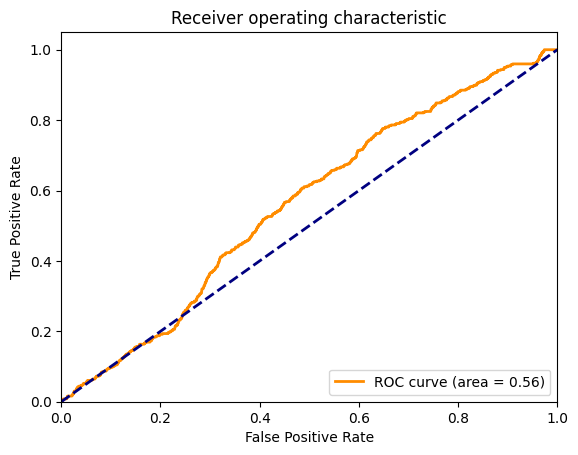

The optimal threshold is: 0.7804990410804749


In [10]:
model.roc_flag = True
thres = utils.find_threshold(pred_probs,gts)
model.roc_flag = False

In [ ]:
# Set new lane threshold and resume training
model.lane_threshold = thres
# Train the model
train(model, train_loader,val_loader= None , num_epochs= 2, 
      lane_weight = None, lr_scheduler= False, lr = 0.001)

In [28]:
# Evaluate on a single sample (for now)
model.eval()
img_tens, gt = train_set[0]
img_tens = img_tens.unsqueeze(0)
test = model(img_tens)

In [29]:
test.squeeze(dim=0).shape

torch.Size([1, 640, 640])

In [30]:
test = test.squeeze(dim=0)

In [31]:
test.unique()

tensor([1.])

In [32]:
# plot image and prediction simultaneously
utils.plot_img_pred(img_tens.squeeze(0),test)